In [1]:
import os
import pandas as pd
os.environ["JAVA_HOME"] = "/scratch/sg7729/jdk8u292-b10/"
os.environ["SPARK_HOME"] = "/scratch/sg7729/spark-3.1.1-bin-hadoop3.2/"

In [2]:
import os

# Your directory path
directory_path = '/home/sg7729/.local/bin'

# Add the directory to the PATH environment variable
os.environ['PATH'] = f"{directory_path}:{os.environ['PATH']}"


In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

23/12/07 11:30:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:

data_folder = '/scratch/sg7729/Big data Project/Bigdata/'
high_volume_filename = '/scratch/sg7729/Big data Project/Bigdata/high_volume.csv'
green_taxi_filename = '/scratch/sg7729/Big data Project/Bigdata/green_taxi.csv'
yellow_taxi_filename = '/scratch/sg7729/Big data Project/Bigdata/yellow_taxi.csv'

In [5]:
green_taxi_data = spark.read.csv(green_taxi_filename, header=True)
high_volume_data= spark.read.csv(high_volume_filename, header=True)
yellow_taxi_data = spark.read.csv(yellow_taxi_filename, header=True)

In [6]:

# Display the schema of each DataFrame
print("Green Taxi Data Schema:")
# Drop the _c0 column
green_taxi_data = green_taxi_data.drop("_c0")

print("\nYellow Taxi Data Schema:")
# Drop the _c0 column
yellow_taxi_data = yellow_taxi_data.drop("_c0")

print("\nHigh Volume Data Schema:")
# Drop the _c0 column
high_volume_data = high_volume_data.drop("_c0")

Green Taxi Data Schema:

Yellow Taxi Data Schema:

High Volume Data Schema:


In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour,dayofmonth
from pyspark.sql.types import TimestampType

In [8]:
# Convert datetime columns to timestamp
green_taxi_data = green_taxi_data.withColumn("pickup_datetime", col("lpep_pickup_datetime").cast(TimestampType()))
yellow_taxi_data = yellow_taxi_data.withColumn("pickup_datetime", col("tpep_pickup_datetime").cast(TimestampType()))
high_volume_data = high_volume_data.withColumn("pickup_datetime", col("pickup_datetime").cast(TimestampType()))

# Feature engineering - Extract hour of the day
green_taxi_data = green_taxi_data.withColumn("hour_of_day", hour(col("pickup_datetime")))
yellow_taxi_data = yellow_taxi_data.withColumn("hour_of_day", hour(col("pickup_datetime")))
high_volume_data = high_volume_data.withColumn("hour_of_day", hour(col("pickup_datetime")))

# Feature engineering - Extract day of the month
green_taxi_data = green_taxi_data.withColumn("day_of_the_month", dayofmonth(col("pickup_datetime")))
yellow_taxi_data = yellow_taxi_data.withColumn("day_of_the_month", dayofmonth(col("pickup_datetime")))
high_volume_data = high_volume_data.withColumn("day_of_the_month", dayofmonth(col("pickup_datetime")))


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, round
from pyspark.sql.types import FloatType

# Create Spark session
spark = SparkSession.builder.appName("FeatureEngineering").getOrCreate()

# Assuming your DataFrame is named 'df'
# If not, replace 'df' with the actual DataFrame name

# df = green_taxi_data.drop(*columns_to_drop)
df = green_taxi_data

# Task 2: Convert and create a new column 'total_fare'
df = df.withColumn('total_amount', col('total_amount').cast(FloatType())) \
       .withColumn('congestion_surcharge', when(col('congestion_surcharge').cast(FloatType()).isNotNull(),
                                                 col('congestion_surcharge').cast(FloatType())).otherwise(0.0)) \
       .withColumn('total_fare', round(col('total_amount') + col('congestion_surcharge'), 2)) \
       .drop('total_amount', 'congestion_surcharge')

green_taxi_cleaned_data = df

In [11]:
# Assuming df is your DataFrame

from pyspark.sql.functions import col, unix_timestamp
# Let's assume that 'lpep_pickup_datetime' and 'lpep_dropoff_datetime' are in the format 'yyyy-MM-dd HH:mm:ss'
df = df.withColumn("lpep_pickup_datetime", unix_timestamp("lpep_pickup_datetime", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))
df = df.withColumn("lpep_dropoff_datetime", unix_timestamp("lpep_dropoff_datetime", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))

# Calculate trip duration in seconds
df = df.withColumn("trip_duration_seconds", (col("lpep_dropoff_datetime").cast("long") - col("lpep_pickup_datetime").cast("long")))

# Optionally, you can convert trip duration to minutes
df = df.withColumn("trip_duration_minutes", col("trip_duration_seconds") / 60.0)

In [15]:

green_taxi_cleaned_data = df.select("trip_duration_minutes", "total_fare", "trip_distance", "PULocationID", "DOLocationID")

green_taxi_cleaned_data = green_taxi_cleaned_data.dropDuplicates(["trip_duration_minutes", "total_fare", "trip_distance", "PULocationID", "DOLocationID"])

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, round
from pyspark.sql.types import FloatType

# Create Spark session
spark = SparkSession.builder.appName("FeatureEngineering").getOrCreate()

# Assuming your DataFrame is named 'df'
# If not, replace 'df' with the actual DataFrame name

# Task 1: Drop specified columns
columns_to_drop = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag',
                   'RatecodeID', 'DOLocationID', 'passenger_count', 'fare_amount',
                   'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
                   'payment_type', 'trip_type', 'pickup_datetime']

# df = yellow_taxi_data.drop(*columns_to_drop)
df = yellow_taxi_data
# Task 2: Convert and create a new column 'total_fare'
df = df.withColumn('total_amount', col('total_amount').cast(FloatType())) \
       .withColumn('Airport_fee', when(col('Airport_fee').cast(FloatType()).isNotNull(),
                                                 col('Airport_fee').cast(FloatType())).otherwise(0.0)) \
       .withColumn('congestion_surcharge', when(col('congestion_surcharge').cast(FloatType()).isNotNull(),
                                                 col('congestion_surcharge').cast(FloatType())).otherwise(0.0)) \
       .withColumn('total_fare', round(col('total_amount') + col('congestion_surcharge') + col('Airport_fee'), 2)) \
       .drop('total_amount', 'congestion_surcharge', 'Airport_fee')

yellow_taxi_cleaned_data = df 

In [16]:
# Assuming df is your DataFrame

from pyspark.sql.functions import col, unix_timestamp
# Let's assume that 'lpep_pickup_datetime' and 'lpep_dropoff_datetime' are in the format 'yyyy-MM-dd HH:mm:ss'
df = df.withColumn("lpep_pickup_datetime", unix_timestamp("lpep_pickup_datetime", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))
df = df.withColumn("lpep_dropoff_datetime", unix_timestamp("lpep_dropoff_datetime", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))

# Calculate trip duration in seconds
df = df.withColumn("trip_duration_seconds", (col("lpep_dropoff_datetime").cast("long") - col("lpep_pickup_datetime").cast("long")))

# Optionally, you can convert trip duration to minutes
df = df.withColumn("trip_duration_minutes", col("trip_duration_seconds") / 60.0)

yellow_taxi_cleaned_data = df.select("trip_duration_minutes", "total_fare", "trip_distance", "PULocationID", "DOLocationID")
yellow_taxi_cleaned_data = yellow_taxi_cleaned_data.dropDuplicates(["trip_duration_minutes", "total_fare", "trip_distance", "PULocationID", "DOLocationID"])


In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, round
from pyspark.sql.types import FloatType

# Create Spark session
spark = SparkSession.builder.appName("FeatureEngineering").getOrCreate()

# Assuming your DataFrame is named 'df'
# If not, replace 'df' with the actual DataFrame name

# Task 1: Drop specified columns
columns_to_drop = ['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num', 'request_datetime',
                   'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime',
                   'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge',
                   'airport_fee', 'tips', 'shared_match_flag', 'shared_request_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag']

# df = high_volume_data.drop(*columns_to_drop)

df = high_volume_data
# Task 2: Convert and create a new column 'total_fare'
df = df.withColumn('total_fare', col('driver_pay').cast(FloatType()))

from pyspark.sql.functions import col
df = df.drop("trip_distance")
df = df.select("*", col("trip_miles").cast("float").alias("trip_distance"))


In [25]:
from pyspark.sql.functions import col, unix_timestamp
# Let's assume that 'lpep_pickup_datetime' and 'lpep_dropoff_datetime' are in the format 'yyyy-MM-dd HH:mm:ss'
df = df.withColumn("lpep_pickup_datetime", unix_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))
df = df.withColumn("lpep_dropoff_datetime", unix_timestamp("dropoff_datetime", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))

# Calculate trip duration in seconds
df = df.withColumn("trip_duration_seconds", (col("lpep_dropoff_datetime").cast("long") - col("lpep_pickup_datetime").cast("long")))

# Optionally, you can convert trip duration to minutes
df = df.withColumn("trip_duration_minutes", col("trip_duration_seconds") / 60.0)

In [26]:

high_volume_cleaned_data = df.select("trip_duration_minutes", "total_fare", "trip_distance", "PULocationID", "DOLocationID")
high_volume_cleaned_data = high_volume_cleaned_data.dropDuplicates(["trip_duration_minutes", "total_fare", "trip_distance", "PULocationID", "DOLocationID"])

In [27]:
combined_df = high_volume_cleaned_data.union(yellow_taxi_cleaned_data).union(green_taxi_cleaned_data)
combined_df

trip_duration_minutes,total_fare,trip_distance,PULocationID,DOLocationID
2.066666666666667,0.0,0.07,209,261
0.21666666666666667,0.0,0.03,93,93
7.316666666666666,4.940000057220459,1.8,215,130
2.4166666666666665,5.380000114440918,0.62,109,109
4.65,5.380000114440918,0.78,241,136
6.233333333333333,5.380000114440918,1.02,91,155
3.9833333333333334,5.380000114440918,1.28,3,184
4.533333333333333,5.380000114440918,1.13,214,214
6.283333333333333,5.380000114440918,0.93,216,216
4.4,5.380000114440918,0.62,241,220


In [28]:
for column in combined_df.columns:
    combined_df = combined_df.withColumn(column, col(column).cast("float"))
df = combined_df

df = df.dropDuplicates(["trip_duration_minutes", "total_fare", "trip_distance", "PULocationID", "DOLocationID"])

In [29]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Assuming you have already created a SparkSession
spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()

# Assuming df is your DataFrame
feature_columns = ["trip_distance", "PULocationID", "DOLocationID"]

# Use StringIndexer for categorical features
categorical_features = [ "PULocationID", "DOLocationID"]

assembler = VectorAssembler(inputCols=["trip_distance"] + [column for column in categorical_features], outputCol="features")

df = assembler.transform(df)

(training_data, testing_data) = df.randomSplit([0.8, 0.2], seed=42)

# Specify the target column ('loction_trip_count') in the labelCol parameter
rf = RandomForestRegressor(labelCol='trip_duration_minutes', featuresCol="features")




In [ ]:
# Train the model
model = rf.fit(training_data)

In [31]:
predictions = model.transform(testing_data)


In [32]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="total_fare", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

Root Mean Squared Error (RMSE) on test data = 10.891603384042266


In [33]:
predictions.show(5)

+---------------------+----------+-------------+------------+------------+--------------------+------------------+
|trip_duration_minutes|total_fare|trip_distance|PULocationID|DOLocationID|            features|        prediction|
+---------------------+----------+-------------+------------+------------+--------------------+------------------+
|          0.033333335|      11.0|          0.0|        53.0|       264.0|    [0.0,53.0,264.0]|13.042190967379863|
|           0.06666667|     111.0|          0.0|        82.0|        82.0|     [0.0,82.0,82.0]|11.285202650403637|
|          0.083333336|     56.01|         0.64|       138.0|       138.0|[0.63999998569488...|13.005540803626303|
|                 0.75|      0.09|          0.0|       129.0|       129.0|   [0.0,129.0,129.0]|10.855465017171586|
|           0.93333334|       0.0|         0.01|        48.0|        48.0|[0.00999999977648...| 11.44218148717334|
+---------------------+----------+-------------+------------+------------+------

In [34]:
selected_df = predictions.select("trip_duration_minutes", "total_fare", "trip_distance", "PULocationID", "DOLocationID", "prediction")
selected_df.write.csv("trip_duration_predictions_sept.csv", header=True, mode="overwrite")

In [ ]:
predictions_df = predictions.select("trip_duration_minutes", "prediction").toPandas()



Text(0, 0.5, 'Frequency')

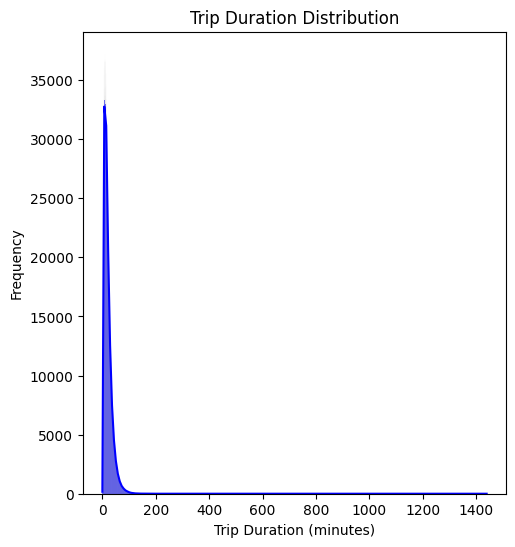

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot trip duration vs. predictions
plt.figure(figsize=(12, 6))

# Plotting trip duration
plt.subplot(1, 2, 1)
sns.histplot(predictions_df['trip_duration_minutes'], kde=True, color='blue')
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

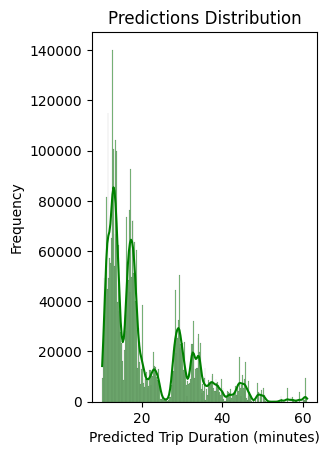

In [37]:
# Plotting predictions
plt.subplot(1, 2, 2)
sns.histplot(predictions_df['prediction'], kde=True, color='green')
plt.title('Predictions Distribution')
plt.xlabel('Predicted Trip Duration (minutes)')
plt.ylabel('Frequency')